# Comparing multiple MVA algorithms with TMVA

In this tutorial we will compare several algorithms with the [Toolkit for Multivariate Data Analysis with ROOT (TMVA)](http://root.cern/tmva) to classify events from particle collisions to determine whether they contain Higgs bosons.

We will skip the analysis of the input dataset (covered in another tutorial) and proceed to the comparison of several algorithms, such as Boosted Decision Trees (BDT), Neural Networks (NN) and Deep Neural Networks (DNN).

In [1]:
# Importing the ROOT module
import ROOT
# Importing the TMVA, TFile (to open ROOT files) and TCut (to filter data)
from ROOT import TMVA, TFile, TCut

# Initialising TMVA
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

Welcome to JupyROOT 6.18/04


In [2]:
# This will overwrite the file at each execution
outputFile = TFile( "TMVA-Classification-Higgs-MVA-Comparison.root", "RECREATE" ) 
factory = TMVA.Factory( "TMVAClassHiggsMVAComp", outputFile,
                        "!V:Color:DrawProgressBar:Transformations=I;D;P;G,D:AnalysisType=Classification" )

# Opening the input data
inputFileName = "Higgs_data.root"
inputFile = TFile.Open( inputFileName )

# Retrieve input trees
sigTree = inputFile.Get("sig_tree")
bkgTree = inputFile.Get("bkg_tree")

#Instantiating the DataLoader
loader = TMVA.DataLoader("dataset")

# Global event weights per tree: useful to adjust the event weight to match a given luminosity
sigWeight = 1.0
bkgWeight = 1.0

# Note: one can add any number of trees (e.g. multiple backgrounds)
loader.AddSignalTree    ( sigTree, sigWeight )
loader.AddBackgroundTree( bkgTree, bkgWeight )

# Adding variables (here corresponding to the branches of the TTree)
loader.AddVariable("m_jj")
loader.AddVariable("m_jjj")
loader.AddVariable("m_lv")
loader.AddVariable("m_jlv")
loader.AddVariable("m_bb")
loader.AddVariable("m_wbb")
loader.AddVariable("m_wwbb")

# Apply additional cuts on the signal and background samples (can be different)
sigCut = TCut("")   ## for example: TCut sigCut = "m_jj>100"
bkgCut = TCut("")   ## for example: TCut bkgCut = "m_jj>100"


loader.PrepareTrainingAndTestTree( sigCut, bkgCut,
         "nTrain_Signal=7000:nTrain_Background=7000:SplitMode=Random:"
         "NormMode=NumEvents:!V" )


# Booking a BDT
factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
          "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
          "BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" )

<ROOT.TMVA::MethodBDT object ("BDT") at 0x7f84cb724200>

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree sig_tree of type Signal with 10000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree bkg_tree of type Background with 10000 events
Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 7000
                         : Signal     -- testing events             : 3000
                         : Signal     -- training and testing events: 10000
                         : Background -- training events            : 7000
                         : Background -- test

In [3]:
# Booking PyGTB (Gradient Trees Boosted), see http://oproject.org/pages/PyMVA.html
factory.BookMethod(loader, ROOT.TMVA.Types.kPyGTB, "PyGTB",
          "H:!V:VarTransform=G:NEstimators=400:LearningRate=0.1:MaxDepth=3" )

# Booking PyRandomForest, see http://oproject.org/pages/PyMVA.html
factory.BookMethod(loader, ROOT.TMVA.Types.kPyRandomForest, "PyRandomForest",
          "!V:VarTransform=G:NEstimators=400:Criterion=gini:MaxFeatures=auto:MaxDepth=6:MinSamplesLeaf=3:"
          "MinWeightFractionLeaf=0:Bootstrap=kTRUE" )

# Booking PyAdaBoost, see http://oproject.org/pages/PyMVA.html      
factory.BookMethod(loader, ROOT.TMVA.Types.kPyAdaBoost, "PyAdaBoost","!V:VarTransform=G:NEstimators=400" )


<ROOT.TMVA::MethodPyAdaBoost object ("PyAdaBoost") at 0x7f84ce8c9c00>

Factory                  : Booking method: PyGTB
                         : 
PyGTB                    : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
Factory                  : Booking method: PyRandomForest
                         : 
PyRandomForest           : [dataset] : Create Transformation "G" 

In [4]:
# Booking several instances Neural Networks using different interfaces

# Built-in Multi-Layer Perceptron (MLP)
factory.BookMethod(loader, ROOT.TMVA.Types.kMLP, "MLP",
          "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=100:HiddenLayers=N+5:TestRate=5:!UseRegulator" );

Factory                  : Booking method: MLP
                         : 
MLP                      : [dataset] : Create Transformation "N" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
MLP                      : Building Network. 
                         : Initializing weights


In [5]:
# Booking a Deep Neural Network (DNN)

# Defining training strategy using ADAM optimiser without regularisation
trainAdamNoReg  = "Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,"
trainAdamNoReg += "DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1"
 
# Defininig training strategy using ADAM optimiser with L2 regularisation
trainAdamL2  = "Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=L2,WeightDecay=1e-4,"
trainAdamL2 += "DropConfig=0.0+0.0+0.0+0,MaxEpochs=20,ConvergenceSteps=10,BatchSize=1000,TestRepetitions=1"            

# Configuring DNN                                                                                                                                                             
dnnOptions = "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU"

# Defining input layer
dnnOptions +=  ":" + "InputLayout=1|1|7"
dnnOptions +=  ":" + "BatchLayout=1|32|7"
dnnOptions +=  ":" + "Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR"
dnnOptions +=  ":" + "TrainingStrategy=" + trainAdamNoReg


# Booking the model with TMVA              
factory.BookMethod(loader, ROOT.TMVA.Types.kDL, "DL_CPU", dnnOptions)

<ROOT.TMVA::MethodDL object ("DL_CPU") at 0x7f84cda0b000>

Factory                  : Booking method: DL_CPU
                         : 
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU:InputLayout=1|1|7:BatchLayout=1|32|7:Layout=DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|64|TANH,DENSE|1|LINEAR:TrainingStrategy=Optimizer=ADAM,LearningRate=1e-3,Momentum=0.,Regularization=None,WeightDecay=1e-4,DropConfig=0.+0.+0.+0.,MaxEpochs=30,ConvergenceSteps=10,BatchSize=32,TestRepetitions=1"
                         : The following options are set:
                         : - By User:
                         :     <none>
                         : - Default:
                         :     Boost_num: "0" [Number of times the classifier will be boosted]
                         : Parsing option string: 
                         : ... "!H:V:ErrorStrategy=CROSSENTROPY:VarTransform=G:WeightInitialization=XAVIER::Architecture=CPU:I

## Using external libraries to train (e.g. Keras)

There are many algorithms and implementations out there to perform machine learning tasks. Some of the more famous frameworks are Keras, Tensorflow. Other libraries such as PyTorch target computer vision and natural language processing (NLP).

TMVA has the ability to book algorithms from Keras using the Tensorflow backend.

Please note that this won't work on your system if you don't have some of the packages installed. You can install them using the commands below:

```
pip install --user tensorflow==1.15
pip install --user keras
```

You might need to install `pip`. Instructions are available [here](https://pip.pypa.io/en/stable/installing/).

In [6]:
# Telling Keras to use the Tensorflow backend
import os
# For this purpose, we set the environment variable KERAS_BACKEND
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importing Keras models, optimizers and layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape

# Setting up our model
model = Sequential()
# We start with a model with 7 inputs (corresponding to our 7 input variables) and 64 outputs
# We will use tanh activation. For more info, see https://keras.io/activations/
# For more information about the parameters, check https://keras.io/layers/core/
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh', input_dim=7))
# We add another layer. Note that the input dimension doesn't need to be specified anymore!
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
# And another layer
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
# Finally, our last layer will have 2 outputs (corresponding to signal and background)
# The softmax function will normalise the output into a probability distribution
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

# We define the loss function and optimisation strategy
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])

# Keras stores the model in the H5 format, so we need to specify a file name
model.save('higgs_dnn_1.h5')

# Print summary of model
model.summary()

factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, "Keras_Dense",
          "H:!V:VarTransform=G:FilenameModel=higgs_dnn_1.h5:"
          "NumEpochs=30:BatchSize=32:TriesEarlyStopping=10")

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 8,962
Trainable params: 8,962
Non-trainable params: 0
_________________________________________________________________


<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0x7f84d0178a00>

Factory                  : Booking method: Keras_Dense
                         : 
Keras_Dense              : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_jj' <---> Output : variable 'm_jj'
                         : Input : variable 'm_jjj' <---> Output : variable 'm_jjj'
                         : Input : variable 'm_lv' <---> Output : variable 'm_lv'
                         : Input : variable 'm_jlv' <---> Output : variable 'm_jlv'
                         : Input : variable 'm_bb' <---> Output : variable 'm_bb'
                         : Input : variable 'm_wbb' <---> Output : variable 'm_wbb'
                         : Input : variable 'm_wwbb' <---> Output : variable 'm_wwbb'
                         : Using TensorFlow backend - setting special configuration options 
                         : Load model from file: hig

2020-01-29 22:32:28.969976: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-29 22:32:29.001718: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f84d132b530 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-01-29 22:32:29.001743: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [7]:
factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()


Train on 11200 samples, validate on 2800 samples
Epoch 1/30
11200/11200 [==============================] - 1s 116us/step - loss: 0.6638 - categorical_accuracy: 0.6018 - val_loss: 0.6260 - val_categorical_accuracy: 0.6461

Epoch 00001: val_loss improved from inf to 0.62599, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 2/30
11200/11200 [==============================] - 1s 90us/step - loss: 0.6335 - categorical_accuracy: 0.6379 - val_loss: 0.6087 - val_categorical_accuracy: 0.6418

Epoch 00002: val_loss improved from 0.62599 to 0.60871, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 3/30
11200/11200 [==============================] - 1s 93us/step - loss: 0.6057 - categorical_accuracy: 0.6662 - val_loss: 0.5681 - val_categorical_accuracy: 0.6875

Epoch 00003: val_loss improved from 0.60871 to 0.56812, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 4/30
11200/11200 [==============================] - 1s 81us/step - loss: 0.5918 - c

0%, time left: unknown
7%, time left: 1 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 1 sec
32%, time left: 1 sec
38%, time left: 1 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
1%, time left: unknown
8%, time left: 12 sec
14%, time left: 12 sec
20%, time left: 12 sec
26%, time left: 10 sec
33%, time left: 9 sec
39%, time left: 8 sec
45%, time left: 7 sec
51%, time left: 6 sec
58%, time left: 5 sec
64%, time left: 4 sec
70%, time left: 3 sec
76%, time left: 3 sec
83%, t

Each method produced a weight file in XML format which can be re-used to apply the method to other inputs. In addition a C++ standalone code is created to integrate the methods into other programmes.

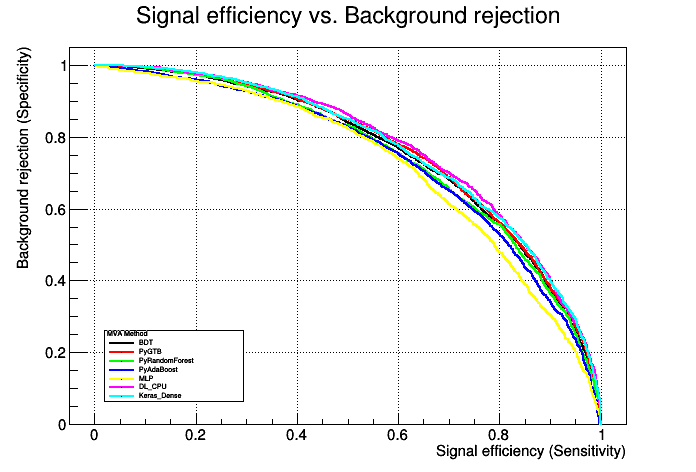

In [8]:
# We can now compare with our first BDT
cROC = factory.GetROCCurve(loader)
cROC.Draw()

In [9]:
# Closing the file where we have the methods trained
outputFile.Close()
factory.Delete()

## Follow-up

There are many, many parameters to all these models.

### Exploring the methods using the TMVAGui

TMVA comes with the TMVAGui, which helps understand how the algorithms behave. To run it, simply run
```
root -l -e 'TMVA::TMVAGui("TMVA-Classification-Higgs-MVA-Comparison.root")'
```
from your terminal.

### Dropout

For example, Deep Neural Networks are prompt to overfitting because of the large amount of parameters, esp. when the input dataset is small. You can try to see the impact yourself by reducing the size of the training and testing samples.


To reduce over-fitting, we can use ensembles of NN with different configurations. However, these require significan computing resources to train and maintain multiple models. Dropout is a technique which randomly disables some of the hidden nodes during training, which simulates having a large number of different network architectures. It offers an effective and computationally cheap regularisation method to reduce overfitting and improve generalisation error.

One can quickly add a dropout to the Keras example by simply adding
```
model.add(Dropout(0.2))
```
before the layer where the dropping of nodes should happend (i.e. the function disables inputs). In the example above, 20% of the inputs will be dropped. For more information, see https://keras.io/layers/core/